In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    # fashion mnist have 10 classes
    pairs = []
    labels = []
    # get the minimum of images of all classes
    n = min([len(digit_indices[d]) for d in range(10)])-1

    for d in range(10):
      for i in range(n):
        # same class
        z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
        pairs += [[x[z1], x[z2]]]
        inc = random.randrange(1, 10)
        dn = (inc+d)%10
        # diffs class
        z1, z2 = digit_indices[d][i], digit_indices[dn][i]
        pairs += [[x[z1], x[z2]]]
        # labels [pos, neg]
        labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images /= 255.0
test_images /= 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4422102/4422102 [==============================] - 0s 0us/step


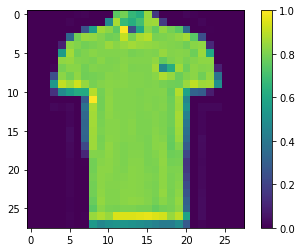

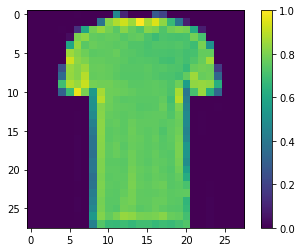

1.0


In [5]:
# array index
this_pair = 10

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

In [6]:
def initialize_base_network():
  '''
  create base network which is sequenctially stacked
  '''
  input = Input(shape=(28, 28), name='base_input')
  x = Flatten(name='flatten_input')(input)
  x = Dense(128, activation='relu', name='first_base_dense')(x)
  x = Dropout(0.1, name='first_dropout')(x)
  x = Dense(128, activation='relu', name='second_base_dense')(x)
  x = Dropout(0.1, name='second_dropout')(x)
  x = Dense(128, activation='relu', name='third_base_dense')(x)

  return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
  '''
  Calculate euclidean between two vectors
  http://mathonline.wikidot.com/the-distance-between-two-vectors
  '''
  x, y = vects
  sum_squares = K.sum(K.square(x-y), axis=1, keepdims=True)
 
  return K.sqrt(K.maximum(sum_squares, K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

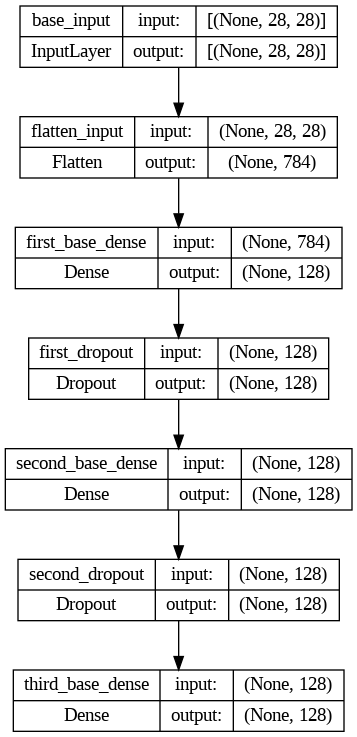

In [9]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

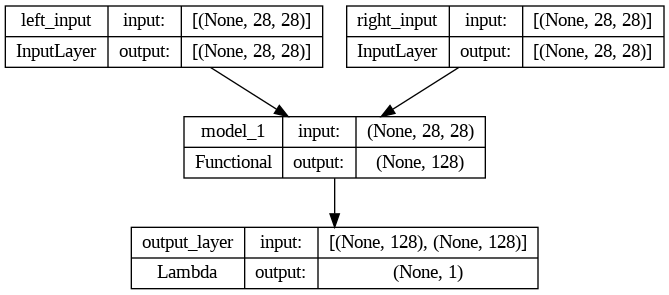

In [10]:
# create the left input and point to the base network
input_a = Input(shape=(28, 28), name='left_input')
vector_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28, 28), name='right_input')
vector_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
lambda_layer = Lambda(function=euclidean_distance, output_shape=eucl_dist_output_shape, name='output_layer')
output = lambda_layer([vector_output_a, vector_output_b])

# specify the inputs and output of the model
model = Model(inputs=[input_a, input_b],outputs=output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

Contrastive loss is a loss function used in machine learning to train models for tasks such as image or text similarity and retrieval. It is used to learn a representation of the input data such that semantically similar inputs are mapped closer together in the learned representation.

The idea behind contrastive loss is to learn embeddings (low-dimensional representations) of the inputs such that inputs that are similar are closer to each other in the embedding space, while inputs that are dissimilar are farther apart. Contrastive loss accomplishes this by defining a margin between similar and dissimilar pairs of inputs, and then minimizing the distance between similar inputs and maximizing the distance between dissimilar inputs.

Given a pair of inputs, the contrastive loss function computes a loss based on the distance between the embeddings of the inputs and the margin value. If the inputs are similar, the loss is computed based on the distance between their embeddings and the margin. If the inputs are dissimilar, the loss is computed based on the distance between their embeddings and the negative margin value.

The contrastive loss is often used in conjunction with Siamese neural networks, which use identical subnetworks to process the two input examples and generate their embeddings, before the contrastive loss is computed. The network is then trained using backpropagation to minimize the overall loss.

In [11]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    '''
    Dunno why the author of the course remove the 1/2 away ┐(￣ヘ￣)┌
    Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin-y_pred, 0))
    return ((1 - y_true) * margin_square + y_true * square_pred)
  return contrastive_loss
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit(
    x=[tr_pairs[:, 0], tr_pairs[:, 1]],
    y=tr_y,
    epochs=20,
    batch_size=128,
    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y)
)

Epoch 1/20
938/938 [==============================] - 18s 15ms/step - loss: 0.1107 - val_loss: 0.0889
Epoch 2/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0807 - val_loss: 0.0772
Epoch 3/20
938/938 [==============================] - 11s 11ms/step - loss: 0.0729 - val_loss: 0.0720
Epoch 4/20
938/938 [==============================] - 11s 11ms/step - loss: 0.0687 - val_loss: 0.0717
Epoch 5/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0652 - val_loss: 0.0684
Epoch 6/20
938/938 [==============================] - 12s 12ms/step - loss: 0.0633 - val_loss: 0.0661
Epoch 7/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0613 - val_loss: 0.0712
Epoch 8/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0601 - val_loss: 0.0672
Epoch 9/20
938/938 [==============================] - 12s 12ms/step - loss: 0.0586 - val_loss: 0.0646
Epoch 10/20
938/938 [==============================] - 11s 12ms/step - loss: 0.057

625/625 [==============================] - 3s 4ms/step
Loss = 0.06338706612586975, Train Accuracy = 0.9423403900650108 Test Accuracy = 0.9152652652652653


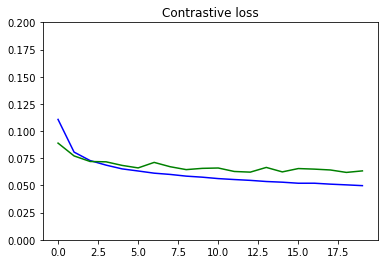

In [12]:
def compute_accuracy(y_true, y_pred):
  '''
  Compute classification accuracy with a fixed threshold on distances
  '''
  pred = y_pred.ravel() < 0.5
  return np.mean(pred==y_true)
loss = model.evaluate(x=[ts_pairs[:,0], ts_pairs[:, 1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color='blue', label=metric_name)
  plt.plot(history.history['val_'+metric_name], color='green', label='val_'+metric_name)
  plt.show()

plot_metrics(metric_name='loss',title='Contrastive loss', ylim=0.2)

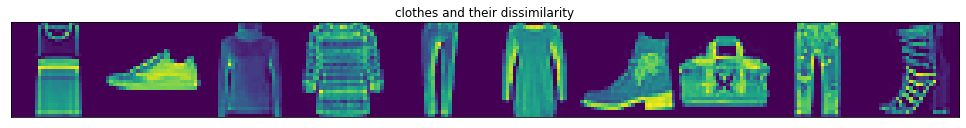

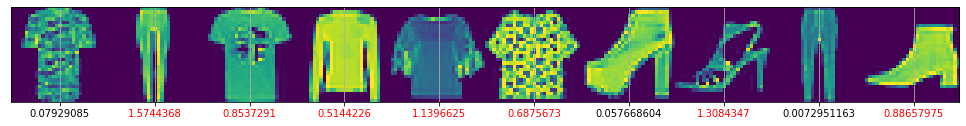

In [13]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:,0][indexes], tr_pairs[:,1][indexes], y_pred_train[indexes], tr_y[indexes], 'clothes and their dissimilarity', 10)